# LOAD PACKAGES

In [52]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style('whitegrid')

from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


# LOAD ORIGINAL TRAINING DATA

In [2]:
# Load training data
dates_ = range(1, 22)
dates = ["{:02d}".format(item) for item in dates_] 

# Read in order data
order_train = pd.concat( pd.read_table('../../../../../../data/season_2/training_data/order_data/order_data_2016-01-%s' %i, header=None, names = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time' ])
                      for i in dates)

# Convert to datetime
order_train['Time'] = pd.to_datetime(order_train['Time'])  

# Read in poi data
poi_train = pd.read_table('../../../../../../data/season_2/training_data/poi_data/poi_data', sep=' ', header=None, names = ['district_hash'])
poi_train = pd.DataFrame(poi_train.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash','poi_class'])

# Read in traffic data
traffic_train = pd.concat( pd.read_table('../../../../../../data/season_2/training_data/traffic_data/traffic_data_2016-01-%s' %i, sep=' ', header=None, names = ['district_hash_orig', 'time'])
                        for i in dates)

split1 = pd.DataFrame(traffic_train.district_hash_orig.str.split('[\W+]',1).tolist())
traffic_train['district_hash'] = split1[0]
traffic_train['tj'] = split1[1]

split2 = pd.DataFrame(traffic_train.tj.str.split('(\d{4}\-\d{2}\-\d{2}$)',1).tolist())
traffic_train['tj_level'] = split2[0]
traffic_train['date'] = split2[1]

traffic_train['Time'] = traffic_train.apply(lambda r: str(r.date) + ' '+ str(r.time), axis=1)
traffic_train.drop(['district_hash_orig', 'time', 'tj', 'date'], axis=1, inplace=True)

# Convert to datetime
traffic_train['Time'] = pd.to_datetime(traffic_train['Time'])

# Read in weather data                                                                                                                                                            
weather_train = pd.concat( pd.read_table('../../../../../../data/season_2/training_data/weather_data/weather_data_2016-01-%s' %i, header=None, names = ['Time', 'Weather', 'temperature', 'PM2.5' ])
                        for i in dates)                      

# Convert to datetime
weather_train['Time'] = pd.to_datetime(weather_train['Time']) 

In [3]:
# Load cluster map - generate dictionary to map district_hash to district_id
district = pd.read_table('../../../../../../data/season_2/test_set_2/cluster_map/cluster_map', sep=' ', header=None, names=['district_hash'])
district = pd.DataFrame(district.district_hash.str.split('\W+',1).tolist(), columns = ['district_hash', 'district_id'])
district_dict = district.set_index('district_hash')['district_id'].to_dict()

# FEATURE PROCESSING

In [4]:
######### FUNCTION DEFINITIONS ####################################################
# Map district_hash to district_id
def dist_hash2id(data_frame, hash_col, district_dict):
    idvalue_array = []
    
    for hash_value in data_frame[hash_col]:
        idvalue_array.append(district_dict[hash_value])
    
    return idvalue_array

# Map time_stamp to time_slot
def time_stamp2slot(arr_hour, arr_minute, arr_second):
    time_slot = []
    
    for hour, minu, sec in zip(arr_hour, arr_minute, arr_second):
        time_slot.append(int((6*hour + 0.1*minu + sec/600) + 1))
    
    return time_slot

# Combine num_day and time_slot to create time_axis
def time_axis(num_day, time_slot):
    return (((num_day - 1)*144) + time_slot)


# Calculate demand, supply and gap per time axis slot
# Demand = Number of orders received (ride requests)
# Supply = Number of orders answered
# Gap = Number of orders missed (NA)
def demand_supply(order_frame):
    
    demand = {}
    supply = {}
    gap = {}
    
    # Initialize demand & supply to zero
    for district in range(1,67):
        for time in range(1,31*144):
            demand[(district, time)] = 0;
            supply[(district, time)] = 0;

    # Iterate over all orders to accumulate demand, supply count for each time slot
    for district_id, num_day, time_slot, answered in zip(order_frame['district_id'], order_frame['num_day'], 
                                                         order_frame['time_slot'], order_frame['driver_id']):
        demand[(int(district_id),time_axis(num_day, time_slot))] += 1;
        supply[(int(district_id),time_axis(num_day, time_slot))] += pd.notnull(answered);
        
    # Calculate the demand-supply gap
    for district in range(1,67):
        for time in range(1,31*144):
            gap[(district, time)] = demand[(district, time)] - supply[(district, time)];
    
    # Use time_slot=1 values to prefill three earlier slots
    # These three earlier time slots are needed to ensure that all input features are defined for time_slot=1
    for district in range(1,67):
        for time in [-2, -1, 0]:
            demand[(district, time)] = demand[(district, 1)]
            supply[(district, time)] = supply[(district, 1)]
            gap[(district, time)] = gap[(district, 1)]
    
    return (demand, supply, gap)

In [5]:
####################      ORIGINAL  TRAINING DATA       #############################
# Update ORDER
# IGNORING: order_id, driver_id, passenger_id, price, end_district_hash

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
order_train.set_index('Time', inplace=True)

order_train['num_day'] = order_train.index.day
order_train['time_slot'] = time_stamp2slot(order_train.index.hour, order_train.index.minute, order_train.index.second)

order_train.reset_index(inplace='True')

order_train['week_day'] = order_train['Time'].dt.dayofweek

# Map start_district_hash (1...66)
order_train['district_id'] = dist_hash2id(order_train, 'start_district_hash', district_dict)

# Calculate demand, supply & gap for all district_id & time_slot
d_train = {}
s_train = {}
g_train = {}
d_train, s_train, g_train = demand_supply(order_train)

###################################################################################
# Update POI

# Map district_hash (1...66) to district_id
poi_train['district_id'] = dist_hash2id(poi_train, 'district_hash', district_dict)

# Create sub features for poi_class

###################################################################################
# Update TRAFFIC

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
traffic_train.set_index('Time', inplace=True)

traffic_train['num_day'] = traffic_train.index.day
traffic_train['time_slot'] = time_stamp2slot(traffic_train.index.hour, traffic_train.index.minute, traffic_train.index.second)

traffic_train.reset_index(inplace='True')

traffic_train['week_day'] = traffic_train['Time'].dt.dayofweek

# Map district_hash (1...66) to district_id
traffic_train['district_id'] = dist_hash2id(traffic_train, 'district_hash', district_dict)

# Create sub features for tj_level

###################################################################################
# Update WEATHER

# Create following features - time_slot (1...144), week_day (1...7), num_day(1...31) 
weather_train.set_index('Time', inplace=True)

weather_train['num_day'] = weather_train.index.day
weather_train['time_slot'] = time_stamp2slot(weather_train.index.hour, weather_train.index.minute, weather_train.index.second)

weather_train.reset_index(inplace='True')

weather_train['week_day'] = weather_train['Time'].dt.dayofweek

# GENERATE UNIFIED DATAFRAME

In [46]:
# Create train_set
train_set = pd.DataFrame()

for district in range(1,67):
    for day in range(2,23):
        for time in range(1,145):
            
            weather_data = weather_train[(weather_train.num_day == day) & (weather_train.time_slot == time)]
            
            # check if weather data is missing
            # use previous data if current time slot data is empty
            if weather_data[['Weather']].empty:
                curr_weather = prev_weather
                curr_temperature = prev_temperature
                curr_pollution = prev_pollution
            else:
                curr_weather = int(weather_data[['Weather']].max())
                prev_weather = curr_weather
                curr_temperature = int(weather_data[['temperature']].max())
                prev_temperature = curr_temperature
                curr_pollution = int(weather_data[['PM2.5']].max())
                prev_pollution = curr_pollution
                
                    
            data = {'district_id': [district], 'num_day': [day], 'time_slot': [time],
                    'week_day': [(day+3)%7],
                    'demand': d_train[(district,time_axis(day,time))],
                    'demand_t-1': d_train[(district,time_axis(day,time-1))],
                    'demand_t-2': d_train[(district,time_axis(day,time-2))],
                    'demand_t-3': d_train[(district,time_axis(day,time-3))],
                    'supply': s_train[(district,time_axis(day,time))],
                    'supply_t-1': s_train[(district,time_axis(day,time-1))],
                    'supply_t-2': s_train[(district,time_axis(day,time-2))],
                    'supply_t-3': s_train[(district,time_axis(day,time-3))],
                    'gap': g_train[(district,time_axis(day,time))],
                    'weather': curr_weather,
                    'temperature': curr_temperature,
                    'pollution': curr_pollution
                   }
            df = pd.DataFrame(data, columns=['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
                                             'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
                                             'supply_t-2', 'supply_t-3','gap', 'weather', 'temperature', 
                                             'pollution'])
            train_set = train_set.append(df)

In [47]:
print "Shape of train set:", train_set.shape, "\n\n"
print "Column Headers:", list(train_set.columns.values), "\n\n"
print train_set.dtypes, "\n\n"
print train_set.head(5), "\n\n"
print train_set.describe(), "\n\n"

Shape of train set: (199584, 16) 


Column Headers: ['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1', 'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature', 'pollution'] 


district_id    int64
num_day        int64
time_slot      int64
week_day       int64
demand         int64
demand_t-1     int64
demand_t-2     int64
demand_t-3     int64
supply         int64
supply_t-1     int64
supply_t-2     int64
supply_t-3     int64
gap            int64
weather        int64
temperature    int64
pollution      int64
dtype: object 


   district_id  num_day  time_slot  week_day  demand  demand_t-1  demand_t-2  \
0            1        2          1         5      88          84          90   
0            1        2          2         5      97          88          84   
0            1        2          3         5      75          97          88   
0            1        2          4         5      60          75      

# TRAIN / VALIDATE / TEST SPLIT

In [ ]:
# Split train / test data - for coarse training
train_days     = range(2,16)
train_times    = range(39,140,4)
validate_days  = [16, 18, 20]
validate_times = range(39,140,4)
test_days      = [17, 19, 21]
test_times     = range(40,141,4)

X_train     = train_set[(train_set['num_day'].isin(train_days)) & (train_set['time_slot'].isin(train_times))]
X_validate  = train_set[(train_set['num_day'].isin(validate_days)) & (train_set['time_slot'].isin(validate_times))]
X_test      = train_set[(train_set['num_day'].isin(test_days)) & (train_set['time_slot'].isin(test_times))]

print "Shape of X_train, X_validate, X_test:", X_train.shape, X_validate.shape, X_test.shape, "\n\n"

print "X_train\n"
print X_train.head(5), "\n\n"
print X_train.describe(), "\n\n"

print "X_validate\n"
print X_validate.head(5), "\n\n"
print X_validate.describe(), "\n\n"

print "X_test\n"
print X_test.head(5), "\n\n"
print X_test.describe(), "\n\n"

# DEMAND (r) FORECAST - SIMPLE AVERAGE

In [80]:
#['district_id', 'num_day', 'time_slot', 'week_day', 'demand', 'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1', 'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature', 'pollution'] 

r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 

rX_train    = X_train[r_predictors]
rX_validate = X_validate[r_predictors]
rX_test     = X_test[r_predictors]

ry_pred_train    = rX_train.apply   (lambda r: (r['demand_t-1'] + r['demand_t-2'] + r['demand_t-3'])/3.0, axis=1)
ry_pred_validate = rX_validate.apply(lambda r: (r['demand_t-1'] + r['demand_t-2'] + r['demand_t-3'])/3.0, axis=1)
ry_pred_test     = rX_test.apply    (lambda r: (r['demand_t-1'] + r['demand_t-2'] + r['demand_t-3'])/3.0, axis=1)

ry_train    = X_train['demand']
ry_validate = X_validate['demand']
ry_test     = X_test['demand']

# Evaluate Scores - Mean Squared, R2
m2score_train    = metrics.mean_squared_error(ry_train,    ry_pred_train)
m2score_validate = metrics.mean_squared_error(ry_validate, ry_pred_validate)
m2score_test     = metrics.mean_squared_error(ry_test,     ry_pred_test)

r2score_train    = metrics.r2_score(ry_train,    ry_pred_train)
r2score_validate = metrics.r2_score(ry_validate, ry_pred_validate)
r2score_test     = metrics.r2_score(ry_test,     ry_pred_test)

sets_list = ["TRAIN", "VALIDATE", "TEST"]
m2_scores = [m2score_train, m2score_validate, m2score_test]
r2_scores = [r2score_train, r2score_validate, r2score_test]

print '\t\tM2\t\tR2'

for s, m, r in zip(sets_list, m2_scores, r2_scores):
    print '{0:10}\t{1:.2f}\t\t{2:.2f}' .format(s, m, r)

		M2		R2
TRAIN     	784.82		0.93
VALIDATE  	1055.78		0.94
TEST      	888.39		0.94


# SUPPLY (a) FORECAST - SIMPLE AVERAGE

In [84]:
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3'] 

aX_train    = X_train[a_predictors]
aX_validate = X_validate[a_predictors]
aX_test     = X_test[a_predictors]

ay_pred_train    = aX_train.apply   (lambda r: (r['supply_t-1'] + r['supply_t-2'] + r['supply_t-3'])/3.0, axis=1)
ay_pred_validate = aX_validate.apply(lambda r: (r['supply_t-1'] + r['supply_t-2'] + r['supply_t-3'])/3.0, axis=1)
ay_pred_test     = aX_test.apply    (lambda r: (r['supply_t-1'] + r['supply_t-2'] + r['supply_t-3'])/3.0, axis=1)

ay_train    = X_train['supply']
ay_validate = X_validate['supply']
ay_test     = X_test['supply']

# Evaluate Scores - Mean Squared, R2
m2score_train    = metrics.mean_squared_error(ay_train,    ay_pred_train)
m2score_validate = metrics.mean_squared_error(ay_validate, ay_pred_validate)
m2score_test     = metrics.mean_squared_error(ay_test,     ay_pred_test)

r2score_train    = metrics.r2_score(ay_train,    ay_pred_train)
r2score_validate = metrics.r2_score(ay_validate, ay_pred_validate)
r2score_test     = metrics.r2_score(ay_test,     ay_pred_test)

sets_list = ["TRAIN", "VALIDATE", "TEST"]
m2_scores = [m2score_train, m2score_validate, m2score_test]
r2_scores = [r2score_train, r2score_validate, r2score_test]

print '\t\tM2\t\tR2'

for s, m, r in zip(sets_list, m2_scores, r2_scores):
    print '{0:10}\t{1:.2f}\t\t{2:.2f}' .format(s, m, r)

		M2		R2
TRAIN     	252.86		0.96
VALIDATE  	262.72		0.97
TEST      	241.56		0.97


# GAP (gap) FORECAST - SIMPLE AVERAGE

In [118]:
def mape_score(exp, pred):
    mape = 0.0
    n = 66.0
    q = 43.0
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [122]:
gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
gapy_pred_validate = [r - a for r, a in zip(ry_pred_validate, ay_pred_validate)]
gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

gapy_train    = X_train['gap']
gapy_validate = X_validate['gap']
gapy_test     = X_test['gap']

# Evaluate Scores - Mean Squared, R2
m2score_train    = metrics.mean_squared_error(gapy_train,    gapy_pred_train)
m2score_validate = metrics.mean_squared_error(gapy_validate, gapy_pred_validate)
m2score_test     = metrics.mean_squared_error(gapy_test,     gapy_pred_test)

r2score_train    = metrics.r2_score(gapy_train,    gapy_pred_train)
r2score_validate = metrics.r2_score(gapy_validate, gapy_pred_validate)
r2score_test     = metrics.r2_score(gapy_test,     gapy_pred_test)

mpscore_train    = mape_score(gapy_train,    gapy_pred_train)
mpscore_validate = mape_score(gapy_validate, gapy_pred_validate)
mpscore_test     = mape_score(gapy_test,     gapy_pred_test)

sets_list = ["TRAIN", "VALIDATE", "TEST"]
m2_scores = [m2score_train, m2score_validate, m2score_test]
r2_scores = [r2score_train, r2score_validate, r2score_test]
mp_scores = [mpscore_train, mpscore_validate, mpscore_test]

print '\t\tMEAN^2\t\tR2\t\tMAPE'

for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
    print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
VALIDATE  	776.12		0.77		0.98
TEST      	639.48		0.77		0.89


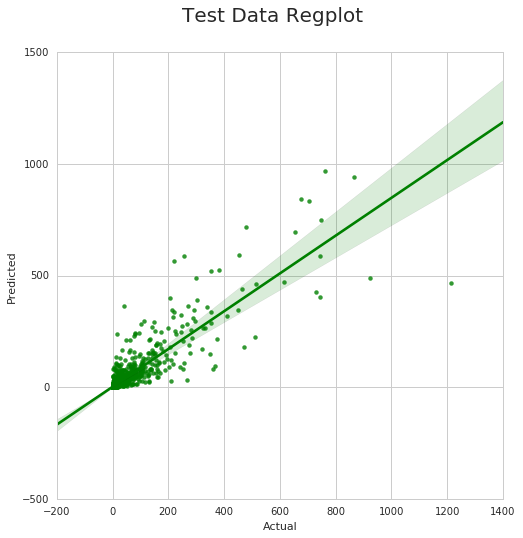

In [117]:
x, y = pd.Series(gapy_test, name="Actual"), pd.Series(gapy_pred_test, name="Predicted")

f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('Test Data Regplot', fontsize=20)
sns.regplot(x=x, y=y, ax=ax, color="g")

In [106]:
print [int(x) for x in ry_train[:5]]
print [int(x) for x in ay_train[:5]]


print [int(x) for x in ry_pred_train[:5]]
print [int(x) for x in ay_pred_train[:5]]

print [int(x) for x in gapy_pred_train[:5]]
print [x for x in gapy_train[:5]]

[14, 55, 100, 115, 106]
[12, 53, 96, 114, 102]
[19, 28, 59, 96, 118]
[14, 28, 59, 95, 115]
[4, 0, 0, 1, 3]
[2, 2, 4, 1, 4]


# FEATURE IMPORTANCE

In [ ]:
# Assess Feature importance

# Train / Test split for original training data
# Withold 5% from train set for testing
predictors = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    train_set[predictors], train_set['gap'], test_size=0.05, random_state=0)

print ("Original Training Set: {}\nTraining Set: {}\nTesting Set(witheld): {}" .format(train_set.shape, X_train.shape,X_test.shape))


# Normalize features - both training & test (withheld & final)
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
##VRfinal_test_transformed  = scaler.transform(test_set[predictors])

print ("Transformed training, test sets (withheld & final)")

# Scoring Metric - MSE
print ("Use MSE as the score function")

# Initialize the algorithm
# Defaults to mean square error as score
X_train1 = np.delete(X_train_transformed, [7,8], axis=1)

alg = RandomForestRegressor(random_state=1, n_estimators=10000, min_samples_split=50, min_samples_leaf=1)
clf = alg.fit(X_train1, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = ['district_id', 'num_day', 'time_slot', 'week_day', 'demand']
for f in range(X_train1.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                             feature_labels[indices[f]], 
                             importances[indices[f]]))

labels_reordered = [ feature_labels[i] for i in indices]
    
plt.title('Feature Importances')
plt.bar(range(X_train1.shape[1]), 
         importances[indices],
         color='lightblue', 
         align='center')
plt.xticks(range(X_train1.shape[1]), labels_reordered, rotation=90)
plt.xlim([-1, X_train1.shape[1]])
plt.tight_layout()
plt.show()

# PLOTS

In [ ]:
# Plot training data: d, s, g
dplot = []
splot = []
gplot = []

trange   = range(1,21*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d_train[(20,t)])
    splot.append(s_train[(20,t)])
    gplot.append(g_train[(20,t)])

f, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, figsize=(20,15))
plt.xlim(0, pltrange)
ax1.grid(True)
#ax1.set_yticks(np.arange(0,160,20))
ax1.set_xticks(np.arange(0, pltrange,144))
    
sns.tsplot(data=dplot, ax=ax1, value="demand")
sns.tsplot(data=splot, ax=ax2, value="supply")
sns.tsplot(data=gplot, ax=ax3, value="gap")

In [ ]:
d_test = {}
s_test = {}
g_test = {}
d_test, s_test, g_test = demand_supply(order_test)

# Plot a distribution plot
dist = range(15,30)
time = range(21*144,31*144)

dplot = []
splot = []
gplot = []
for t in range(21*144,31*144):
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])

f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=False, figsize=(20,15))

sns.distplot(dplot, hist=False, color="g", kde_kws={"shade": True}, ax=axis1)
sns.distplot(splot, hist=False, color="b", kde_kws={"shade": True}, ax=axis2)
sns.distplot(gplot, hist=False, color="r", kde_kws={"shade": True}, ax=axis3)

In [ ]:
data = {'demand': dplot, 'gap': gplot}
df = pd.DataFrame(data, columns=['demand', 'gap'])

grid = sns.JointGrid(x='demand', y='gap', data=df, size=15, ratio=4)
grid = grid.plot(sns.regplot, sns.distplot)

In [ ]:
#plot test data
dplot = []
splot = []
gplot = []

trange   = range(23*144,31*144)
pltrange = max(trange)-min(trange)

for t in trange:
    dplot.append(d[(20,t)])
    splot.append(s[(20,t)])
    gplot.append(g[(20,t)])
    
f, (axis1,axis2,axis3) = plt.subplots(3,1, sharex=True, figsize=(20,15))

sns.tsplot(data=dplot, ax=axis1, value="demand")
sns.tsplot(data=splot, ax=axis2, value="supply")
sns.tsplot(data=gplot, ax=axis3, value="gap")

plt.xlim(0, pltrange)

axis1.grid(True)

#axis1.set_yticks(np.arange(0,160,20))
axis1.set_xticks(np.arange(0, pltrange,1))

In [ ]:
sns.set(style="ticks")

# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)
df = pd.DataFrame(np.c_[pos.flat, step, walk],
                  columns=["position", "step", "walk"])

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="walk", hue="walk", col_wrap=5, size=1.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "step", "position", marker="o", ms=4)

# Adjust the tick positions and labels
grid.set(xticks=np.arange(5), yticks=[-3, 3],
         xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

# REVIEW INPUT FEATURES

In [4]:
# Review input features (ORDER, POI, TRAFFIC, WEATHER) for original training set - Part 1
names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

for name, feature in zip(names, features):
    print "\n\n-----------------------"
    print "{} TRAIN INFORMATION" .format(str.upper(name))
    print "-----------------------"
    print "Shape of training set:", feature.shape, "\n\n"
    print "Column Headers:", list(feature.columns.values), "\n\n"
    print feature.dtypes, "\n\n"
    print feature.head(5), "\n\n"
    print feature.describe(), "\n\n"
    
# Review input features for train set - Part 2
missing_values = []
nonumeric_values = []

names = ['ORDER', 'POI', 'TRAFFIC', 'WEATHER']
features = [order_train, poi_train, traffic_train, weather_train]

print ("TRAIN SET INFORMATION")
print ("========================\n")

for name,feature in zip(names,features):
    
    print "\n-----------------------"
    print "{} TRAIN INFORMATION" .format(name)
    print "-----------------------\n"
    missing_values = []
    nonumeric_values = []
    
    for column in feature:
        
        # Find all the unique feature values
        uniq = feature[column].unique()
        print ("'{}' has {} unique values" .format(column,uniq.size))
        if (uniq.size > 25):
            print("~~Listing up to 25 unique values~~")
        print (uniq[0:24])
        print ("\n-----------------------------------------------------------------------\n")
            
        # Find features with missing values
        if (True in pd.isnull(uniq)):
            s = "{} has {} missing" .format(column, pd.isnull(feature[column]).sum())
            missing_values.append(s)
    
        # Find features with non-numeric values
        for i in range (1, np.prod(uniq.shape)):
            
            if (re.match('nan', str(uniq[i]))):
                break
            
            if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
                nonumeric_values.append(column)
                break
  
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print ("{} Features with missing values:\n{}\n\n" .format(name, missing_values))
    print ("{} Features with non-numeric values:\n{}" .format(name, nonumeric_values))
    print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")



-----------------------
ORDER TRAIN INFORMATION
-----------------------
Shape of training set: (8540614, 7) 


Column Headers: ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'Price', 'Time'] 


order_id                       object
driver_id                      object
passenger_id                   object
start_district_hash            object
dest_district_hash             object
Price                         float64
Time                   datetime64[ns]
dtype: object 


                           order_id                         driver_id  \
0  97ebd0c6680f7c0535dbfdead6e51b4b  dd65fa250fca2833a3a8c16d2cf0457c   
1  92c3ac9251cc9b5aab90b114a1e363be  c077e0297639edcb1df6189e8cda2c3d   
2  abeefc3e2aec952468e2fd42a1649640  86dbc1b68de435957c61b5a523854b69   
3  cb31d0be64cda3cc66b46617bf49a05c  4fadfa6eeaa694742de036dddf02b0c4   
4  139d492189ae5a933122c098f63252b3                               NaN   

                       passenger_id       